In [28]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization
import random
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from math import sqrt
from sklearn.metrics import mean_squared_error
import warnings # Supress warnings
import winsound

In [2]:
def split_data(df):
    testSize = 100
    train = df.iloc[:-testSize]
    test = df.iloc[-testSize:]
    return train, test

In [3]:
warnings.filterwarnings('ignore')
df = pd.read_csv("./files/Aquifer_Petrignano.csv")

### Simplifications for the sake of the tutorial ###
# Drop data before 2009 for the purpose of this tutorial
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)
# Drop one of the target columns, so we can focus on only one target
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)

# Simplify column names
df.columns = ['Date', 'Rainfall', 'Depth_to_Groundwater', 'Temperature', 'Drainage_Volume', 'River_Hydrometry']

targets = ['Depth_to_Groundwater']
features = [feature for feature in df.columns if feature not in targets]
from datetime import datetime, date
df.index = pd.to_datetime(df.Date, format = '%d/%m/%Y', )
df = df.drop(['Date'], axis=1)
df.head()

,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry
Date,,,,,
2009-01-01,0.0,-31.14,5.2,-24530.688,2.4
2009-01-02,0.0,-31.11,2.3,-28785.888,2.5
2009-01-03,0.0,-31.07,4.4,-25766.208,2.4
2009-01-04,0.0,-31.05,0.8,-27919.296,2.4
2009-01-05,0.0,-31.01,-1.9,-29854.656,2.3


In [4]:
df['Drainage_Volume'] = df['Drainage_Volume'].interpolate()
df['River_Hydrometry'] = df['River_Hydrometry'].interpolate()
df['Depth_to_Groundwater'] = df['Depth_to_Groundwater'].interpolate()
depth = df['Depth_to_Groundwater']
temp = df['Temperature']
rain = df['Rainfall']
drain = df['Drainage_Volume']
hydro = df['River_Hydrometry']

In [5]:
train_rain, test_rain = split_data(rain)
train_drain, test_drain = split_data(drain)
train_depth, test_depth = split_data(depth)
train_hydro, test_hydro = split_data(hydro)
train_temp, test_temp = split_data(temp)
train = [train_rain, train_depth, train_temp, train_drain, train_hydro]
test = [test_rain, test_depth, test_temp, test_drain, test_hydro]

In [6]:
random.seed(7)

In [60]:
# Rolling LSTM function to fit the LSTM model to training data
train= train_depth
neurons = 4
epochs = 10
X = train[:-1]
y = np.diff(train)
# Convert X and y to NumPy arrays and then reshape
X = np.array(X).reshape(len(X), 1, 1).astype(np.float32)
y = np.array(y).reshape(len(y), 1).astype(np.float32)

model = Sequential()
model.add(LSTM(neurons, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, y, epochs=epochs, batch_size=1, verbose=1)
model

Epoch 1/10
4098/4098 [==============================] - 7s 1ms/step - loss: 0.0052
Epoch 2/10
4098/4098 [==============================] - 5s 1ms/step - loss: 0.0042
Epoch 3/10
4098/4098 [==============================] - 5s 1ms/step - loss: 0.0041
Epoch 4/10
4098/4098 [==============================] - 6s 2ms/step - loss: 0.0041
Epoch 5/10
4098/4098 [==============================] - 6s 1ms/step - loss: 0.0041
Epoch 6/10
4098/4098 [==============================] - 6s 1ms/step - loss: 0.0041
Epoch 7/10
4098/4098 [==============================] - 5s 1ms/step - loss: 0.0041
Epoch 8/10
4098/4098 [==============================] - 5s 1ms/step - loss: 0.0041
Epoch 9/10
4098/4098 [==============================] - 7s 2ms/step - loss: 0.0041
Epoch 10/10
4098/4098 [==============================] - 6s 1ms/step - loss: 0.0041


In [67]:
y.shape

(4098, 1)

In [57]:

# One-step forecast function
def forecast_lstm(model, X):
    X = X.reshape(1, 1, 1).astype(np.float32)
    yhat = model.predict(X, batch_size=1)
    return yhat[0, 0]

In [58]:

# Rolling LSTM implementation
def rolling_lstm(series, split_ratio=0.7, epochs=1, neurons=4):
    size = int(len(series) * split_ratio)
    train, test = series.iloc[:size], series.iloc[size:]  # Slicing the pandas Series correctly

    # Set the random seed to a fixed value
    random.seed(7)

    lstm_model = fit_lstm(train, epochs, neurons)

    # Convert train to a NumPy array and reshape for prediction
    lstm_model.predict(np.array(train).reshape(len(train), 1, 1).astype(np.float32))

    predictions = []
    for i in range(len(test)):
        X, expected = test.iloc[i], test.iloc[i]
        yhat = forecast_lstm(lstm_model, X)
        predictions.append(yhat)

    mse = mean_squared_error(test.values, predictions)
    rmse = sqrt(mse)

    # Convert predictions to pandas Series with datetime index
    prediction_dates = test.index
    predictions = pd.Series(predictions, index=prediction_dates)

    return rmse, predictions

In [50]:
time_series_data = pd.Series([1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                             index=pd.date_range(start='2023-01-01', periods=10, freq='D'))
time_series_data = depth
epoch = 20
neurons = 4

rmse, predictions = rolling_lstm(time_series_data, split_ratio=0.7, epochs=epoch, neurons=neurons)
print(f"RMSE: {rmse:.2f}")


1/1 [==============================] - 0s 21ms/step
RMSE: 25.49


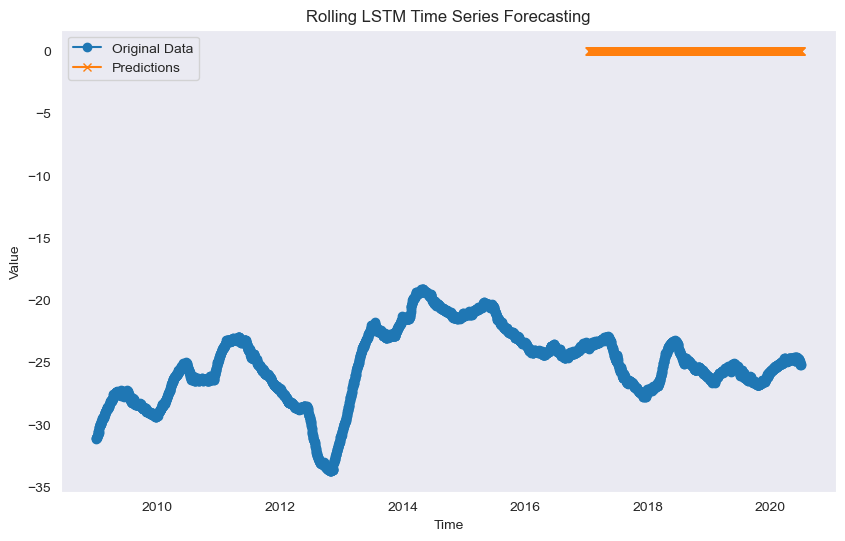

In [51]:

# Plot the original time series data and the predicted values
plt.figure(figsize=(10, 6))
plt.plot(time_series_data, label="Original Data", marker='o')
plt.plot(predictions, label="Predictions", marker='x')
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Rolling LSTM Time Series Forecasting")
plt.legend()
plt.grid()
plt.show()

In [52]:
winsound.Beep(2500,1000)

In [11]:
type(depth)

pandas.core.series.Series

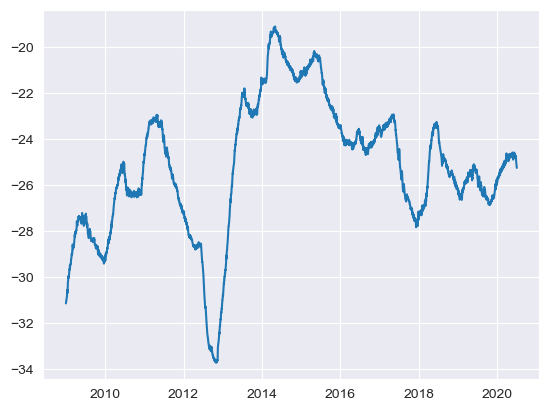

In [55]:
plt.plot(depth)

In [54]:
predictions

Date
2017-01-18    0.014057
2017-01-19    0.014067
2017-01-20    0.014093
2017-01-21    0.014093
2017-01-22    0.014067
                ...   
2020-06-26    0.014677
2020-06-27    0.014692
2020-06-28    0.014721
2020-06-29    0.014717
2020-06-30    0.014743
Length: 1260, dtype: float32

In [21]:
time_series_data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [13]:
type(time_series_data)

list